**<font size = 4> <font color = 'red'> IMPORT MODULES**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

**<font size = 4> <font color = 'red'> READ IN MATCHUP DATA**

In [2]:
nba_series = pd.read_csv("TEAM_MATCHUP_DATA_FINAL.csv") # replace with your path
nba_series['SEASON'] = nba_series['SEASON'].astype(int)

**<font size = 4> <font color = 'red'> SET UP TRAIN/TEST DATA**

In [3]:
# Trained on data from 1997-1999 and tested on 2000 data
train_data_gen = nba_series[nba_series['SEASON'] < 2005]
test_data_gen = nba_series[nba_series['SEASON'] == 2005]

# Separate out the columns to keep for comparison
columns_to_keep = ['SERIES_ID', 'SEASON', 'TEAM_1', 'TEAM_2', 'SERIES_WINNER']
# Save the original data with the columns to keep
train_data_preserved = train_data_gen[columns_to_keep]
test_data_preserved = test_data_gen[columns_to_keep]

# Drop columns before training the model
nba_series = nba_series.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])
train_data_gen = train_data_gen.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])
test_data_gen = test_data_gen.drop(columns = ['SERIES_ID', 'SEASON', 'SEASON_ID', 'TEAM_1_ID', 'TEAM_2_ID'])

# Set up the target variable as TEAM_1_W and drop TEAM_1, TEAM_2, and SERIES_WINNER variables
nba_series['TEAM_1_W'] = (nba_series['SERIES_WINNER'] == nba_series['TEAM_1']).astype(int)
nba_series = nba_series.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])

train_data_gen['TEAM_1_W'] = (train_data_gen['SERIES_WINNER'] == train_data_gen['TEAM_1']).astype(int)
train_data_gen = train_data_gen.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])

test_data_gen['TEAM_1_W'] = (test_data_gen['SERIES_WINNER'] == test_data_gen['TEAM_1']).astype(int)
test_data_gen = test_data_gen.drop(columns = ['TEAM_1', 'TEAM_2', 'SERIES_WINNER'])

**<font size = 4> <font color = 'red'> NEURAL NETWORK TRAINING/TESTING (FULL DATA)**

Epoch 1/50


C:\Users\Sarvesh\anaconda3\envs\NBACluster\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5748 - loss: 0.6866 - val_accuracy: 0.6720 - val_loss: 0.6180
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7585 - loss: 0.5595 - val_accuracy: 0.7460 - val_loss: 0.5488
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7640 - loss: 0.5236 - val_accuracy: 0.7407 - val_loss: 0.5563
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8144 - loss: 0.4275 - val_accuracy: 0.7672 - val_loss: 0.5159
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8130 - loss: 0.4163 - val_accuracy: 0.7989 - val_loss: 0.4966
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8202 - loss: 0.3500 - val_accuracy: 0.7725 - val_loss: 0.5078
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8578 - loss: 0.3094 - val_accuracy: 0.7884 - val_loss: 0.4905
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9184 - loss: 0.2599 - val_accuracy: 0.8042 - val_loss: 0.5282
Ep

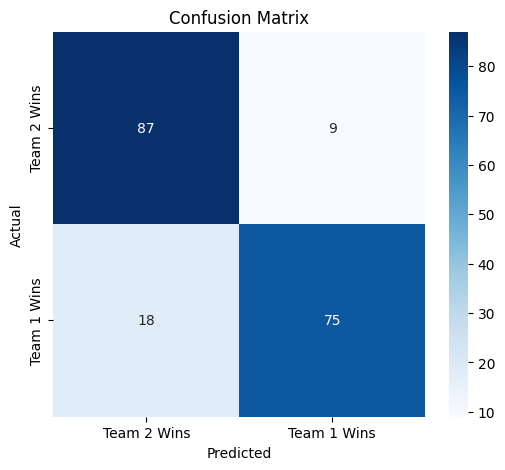

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


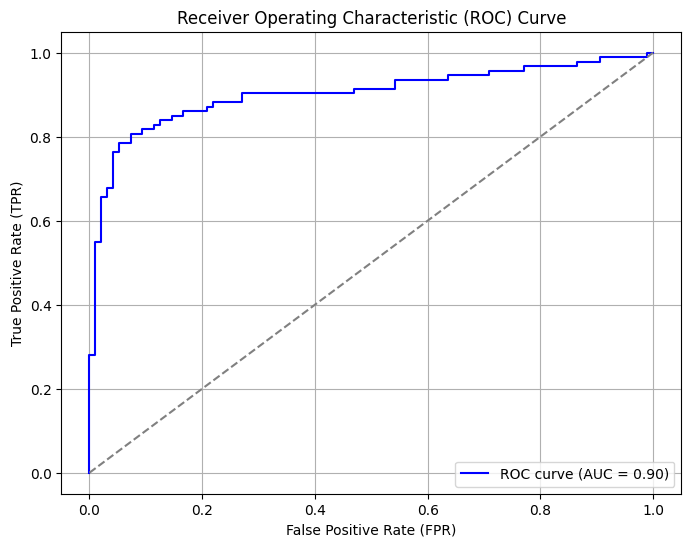

In [7]:
# Load the dataset (nba_series) and separate features (X) and target (y)
X = nba_series.drop(columns=['TEAM_1_W'])
y = nba_series['TEAM_1_W']

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Standardize the features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_dim=X_train.shape[1]),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    class_weight=class_weight_dict, callbacks=[early_stopping])

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Evaluate the model
print(f"Model Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Team 2 Wins', 'Team 1 Wins'], 
            yticklabels=['Team 2 Wins', 'Team 1 Wins'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Get the predicted probabilities for the positive class (Team 1 Wins)
y_prob = model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**<font size = 4> <font color = 'red'> NEURAL NETWORK TRAINING (1997-2004), TESTING (2005)**

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9390 - loss: 0.2358 - val_accuracy: 1.0000 - val_loss: 0.0390
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9096 - loss: 0.2086 - val_accuracy: 1.0000 - val_loss: 0.0522
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9712 - loss: 0.0863 - val_accuracy: 0.9333 - val_loss: 0.1118
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9712 - loss: 0.1207 - val_accuracy: 0.8667 - val_loss: 0.1554
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9477 - loss: 0.1303 - val_accuracy: 0.9333 - val_loss: 0.0920
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9300 - loss: 0.1509 - val_accuracy: 0.8000 - val_loss: 0.3536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Accuracy on 2005 data: 100.00%

Classification Report for 2005 data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00 

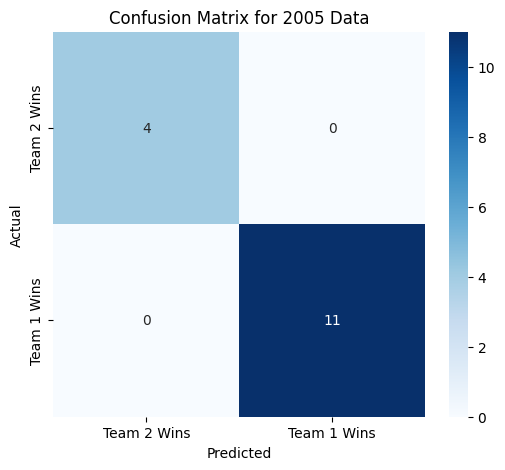

In [9]:
# Make predictions on the 2016 data
# Assuming you have already split into 1997-2015 (training) & 2016 (testing)
X_train_gen = train_data_gen.drop(columns=['TEAM_1_W'])
y_train_gen = train_data_gen['TEAM_1_W']
X_test_gen = test_data_gen.drop(columns=['TEAM_1_W'])
y_test_gen = test_data_gen['TEAM_1_W']

# Standardize the features for 2024 data
X_train_gen = scaler.transform(X_train_gen)
X_test_gen = scaler.transform(X_test_gen)

# Train the model
model.fit(X_train_gen, y_train_gen, epochs=50, batch_size=32, validation_data=(X_test_gen, y_test_gen),
          class_weight=class_weight_dict, callbacks=[early_stopping])

# Make predictions on the 2016 test data
y_pred_gen = (model.predict(X_test_gen) > 0.5).astype("int32")

# Evaluate the model on 2024 data
print(f"Accuracy on 2005 data: {accuracy_score(y_test_gen, y_pred_gen) * 100:.2f}%")
print("\nClassification Report for 2005 data:")
print(classification_report(y_test_gen, y_pred_gen))

# Confusion matrix for 2024 data
cm_24 = confusion_matrix(y_test_gen, y_pred_gen)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_24, annot=True, fmt='d', cmap='Blues', xticklabels=['Team 2 Wins', 'Team 1 Wins'], 
            yticklabels=['Team 2 Wins', 'Team 1 Wins'])
plt.title('Confusion Matrix for 2005 Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**<font size = 4> <font color = 'red'> DISPLAY FINAL RESULTS**

In [11]:
test_data_preserved['PRED_WINNER'] = y_pred_gen
test_data_preserved

,SERIES_ID,SEASON,TEAM_1,TEAM_2,SERIES_WINNER,PRED_WINNER
120,2005_BOS_IND,2005,Boston Celtics,Indiana Pacers,Indiana Pacers,0
121,2005_CHI_WAS,2005,Chicago Bulls,Washington Wizards,Washington Wizards,0
122,2005_DAL_HOU,2005,Dallas Mavericks,Houston Rockets,Dallas Mavericks,1
123,2005_DAL_PHX,2005,Phoenix Suns,Dallas Mavericks,Phoenix Suns,1
124,2005_DEN_SAS,2005,San Antonio Spurs,Denver Nuggets,San Antonio Spurs,1
125,2005_DET_IND,2005,Detroit Pistons,Indiana Pacers,Detroit Pistons,1
126,2005_DET_MIA,2005,Miami Heat,Detroit Pistons,Detroit Pistons,0
127,2005_DET_PHI,2005,Detroit Pistons,Philadelphia 76ers,Detroit Pistons,1
128,2005_DET_SAS,2005,San Antonio Spurs,Detroit Pistons,San Antonio Spurs,1
129,2005_MEM_PHX,2005,Phoenix Suns,Memphis Grizzlies,Phoenix Suns,1
